In [1]:
import sys
sys.path.append('../scripts')
from utils import *
mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<unsigned long, std::allocator<unsigned long> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::vector<std::vector<double, std::allocator<double> >, std::allocator<s

## Open and process synthesis plans on 1000 ZINC "boutique" molecules

In [2]:
# some results failed in the first run, needed to be run and parsed separately.
res_paths = glob.glob ('../../data/boutique_1000*json')
addl_result_ls = []
for path in res_paths:
    print ('Reading in', path)
    with open(path, 'r') as f:
        for entry in f.readlines():
            addl_result_ls.append(json.loads(entry))

print ('File read')      
addl_result_dict = {}
for result in addl_result_ls:
    smiles = list(result.keys())[0]
    if smiles in addl_result_dict.keys():
        addl_result_dict[smiles].update(result[smiles])
    else:
        addl_result_dict[smiles] = result[smiles]
print ('Dictionary defined')
# for these searches, results were returned as the networkX search graph
graph_dict = {}
for smiles in addl_result_dict:
    graph_dict[smiles] = {}
    for prioritizer in addl_result_dict[smiles]:
        if 'output' in addl_result_dict[smiles][prioritizer].keys():
            graph = nx.node_link_graph(addl_result_dict[smiles][prioritizer]['output']).reverse()
            graph_dict[smiles][prioritizer] = graph
        else:
            print ('Search failed for', smiles, prioritizer)
            graph_dict[smiles][prioritizer] = None
print ('Graphs defined')

Reading in ../../run_ASKCOS_tree_builder/6Jun2022_boutique_1000_4.json
Reading in ../../run_ASKCOS_tree_builder/6Jun2022_boutique_1000_0.json
Reading in ../../run_ASKCOS_tree_builder/6Jun2022_boutique_1000_2.json
Reading in ../../run_ASKCOS_tree_builder/6Jun2022_boutique_1000_1.json
Reading in ../../run_ASKCOS_tree_builder/6Jun2022_boutique_1000_3.json
File read
Dictionary defined
Graphs defined


In [3]:
shortest_path_dict = {}
spg_dict = {}

shortest_path_cascade_dict = {}
spg_cascade_dict = {}

for smiles in graph_dict:
    shortest_path_dict[smiles] = {}
    spg_dict[smiles] = {}
    
    shortest_path_cascade_dict[smiles] = {}
    spg_cascade_dict[smiles] = {}
    for prioritizer in graph_dict[smiles]:
        try:
            g = graph_dict[smiles][prioritizer]
            if g and len(g.nodes)>1:
                std_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
                chem_nodes = [n for n in g.nodes if '>>' not in n]
                starting_nodes = [n for n in chem_nodes if g.nodes[n]['terminal']]
                s_p_g = metabolic_dijkstra(g, starting_nodes)
                spg_dict[smiles][prioritizer] = s_p_g
                try:
                    shortest_path_dict[smiles][prioritizer] = s_p_g.nodes[std_smiles]['path_length']
                except:
                    shortest_path_dict[smiles][prioritizer] = s_p_g.nodes[smiles]['path_length']
                s_p_g = metabolic_dijkstra(g, starting_nodes, account_for_one_pot=True)
                spg_cascade_dict[smiles][prioritizer] = s_p_g
                try:
                    shortest_path_cascade_dict[smiles][prioritizer] = s_p_g.nodes[std_smiles]['path_length']
                except:
                    shortest_path_cascade_dict[smiles][prioritizer] = s_p_g.nodes[smiles]['path_length']
                
            else:
                print ('No Graph for', smiles, prioritizer)
        except:
            print ('Graph retrieval failed for', smiles, prioritizer)

print ('Short Paths found')

Short Paths found


In [7]:
shortest_paths = pd.DataFrame(shortest_path_dict).T    
shortest_paths_cascade = pd.DataFrame(shortest_path_cascade_dict).T
any_path_found = shortest_paths.copy()
for idx in shortest_paths.index:
    for col in shortest_paths.columns:
        addl_data = shortest_paths.loc[idx, col]
        if addl_data < np.inf:
            any_path_found.loc[idx, col] = 1
        elif addl_data > 12:
            any_path_found.loc[idx, col] = 0
any_path_found = any_path_found.dropna(axis=0)
any_path_found = any_path_found>0

In [8]:
any_path_found

,"bkms,reaxys",bkms,reaxys
CC[C@H](C)N(C[C@@H](O)c1cccn1Cc1ccccc1Cl)[C@@H](C)CC,False,False,True
C=C(C)[C@@H]1CC=C(C)C[C@@H]1O,True,True,False
C[C@H](C(=O)CC[C@@H](C)CO)[C@H]1C(=O)C[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C,False,False,False
C=CC1=C(C)[C@@H](CC2=N/C(=C3\c4[nH]c(Cc5[nH]c(C=O)c(C)c5CC)c(C)c4C(=O)[C@@H]3C(=O)OC)[C@@H](CCC(=O)O)[C@@H]2C)NC1=O,False,False,False
O=C(COP(=O)(O)O)[C@H](O)[C@H](O)CO,True,True,True
...,...,...,...
C=C(C)[C@H](CC=C(C)C)Cc1c(O)cc(OC)c2c1O[C@H](c1ccc(O)cc1O)[C@H](O)C2=O,False,False,False
c1ccc(-c2nc(N3CCNCC3)cc3ccccc23)cc1,True,False,True
CC1(C)O[C@](C)([C@H]2CC[C@](C)(Cl)[C@@H](Br)C2)[C@H](O)C[C@H]1Br,False,False,False
CNC(=O)CCC(=O)c1cccnc1,True,True,True


In [9]:
shortest_paths 

,"bkms,reaxys",bkms,reaxys
CC[C@H](C)N(C[C@@H](O)c1cccn1Cc1ccccc1Cl)[C@@H](C)CC,inf,inf,10.0
C=C(C)[C@@H]1CC=C(C)C[C@@H]1O,1.0,1.0,inf
C[C@H](C(=O)CC[C@@H](C)CO)[C@H]1C(=O)C[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@@]21C,inf,inf,inf
C=CC1=C(C)[C@@H](CC2=N/C(=C3\c4[nH]c(Cc5[nH]c(C=O)c(C)c5CC)c(C)c4C(=O)[C@@H]3C(=O)OC)[C@@H](CCC(=O)O)[C@@H]2C)NC1=O,inf,inf,inf
O=C(COP(=O)(O)O)[C@H](O)[C@H](O)CO,1.0,2.0,1.0
...,...,...,...
C=C(C)[C@H](CC=C(C)C)Cc1c(O)cc(OC)c2c1O[C@H](c1ccc(O)cc1O)[C@H](O)C2=O,inf,inf,inf
c1ccc(-c2nc(N3CCNCC3)cc3ccccc23)cc1,2.0,inf,2.0
CC1(C)O[C@](C)([C@H]2CC[C@](C)(Cl)[C@@H](Br)C2)[C@H](O)C[C@H]1Br,inf,inf,inf
CNC(=O)CCC(=O)c1cccnc1,2.0,2.0,2.0


In [10]:
unique_enzyme_templates = set(pd.read_csv('../test_molecules/uniquely_enzymatic_template_ids.csv')['_id'].values)
non_reaxys_enzyme_templates = set(pd.read_csv('../test_molecules/enzymatic_template_not_in_reaxys_ids.csv')['_id'].values)

In [11]:
max_depth = 10
max_trees = 5000
validate_paths = True
NIL_UUID = '00000000-0000-0000-0000-000000000000'

In [18]:
#enumerate out the paths for bkms,reaxys graphs that do not have an enzymatic reaction in their shortest path
bkms_used_in_shortest_path = {}
enumerated_hybrid_paths = {}
for smiles in shortest_paths[shortest_paths.loc[:, 'bkms,reaxys']<np.inf].index:
    g = spg_dict[smiles]['bkms,reaxys']
    std_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    
    
    try:
        shortest_path = g.nodes[smiles]['shortest_pathway']
    except:
        shortest_path = g.nodes[std_smiles]['shortest_pathway']
    
    prioritizer = []
    
    any_bkms = False
    for rxn in shortest_path:
        if 'bkms' in g.nodes[rxn]['template_set']:
            any_bkms = True
            break
    bkms_used_in_shortest_path[smiles] = any_bkms
    
    if not any_bkms:
        paths = get_paths(
                    graph_dict[smiles]['bkms,reaxys'].reverse(),
                    root=smiles,
                    root_uuid=NIL_UUID,
                    max_depth=max_depth,
                    max_trees=max_trees,
                    validate_paths=validate_paths,
                )

        enumerated_hybrid_paths[smiles] = nx_paths_to_json(paths, NIL_UUID)

In [19]:
shortest_bio_paths_from_enumeration = {}
shortest_bio_paths_cascade_from_enumeration = {}
for smiles in enumerated_hybrid_paths:
    shortest_bio_paths_from_enumeration[smiles] = get_shortest_path_length(get_pathway_by_prioritizer({'output':enumerated_hybrid_paths[smiles]},
                                                                                     'bkms'))
    shortest_bio_paths_cascade_from_enumeration[smiles] = get_shortest_path_length(get_pathway_by_prioritizer({'output':enumerated_hybrid_paths[smiles]},
                                                                                     'bkms') , account_for_one_pot=True)

Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path
Could not find best path


## Make Venn Diagrams

In [20]:
# sets
bkms_found = set(any_path_found.loc[:, 'bkms'][any_path_found.loc[:, 'bkms']>0].index)
reaxys_found = set(any_path_found.loc[:, 'reaxys'][any_path_found.loc[:, 'reaxys']>0].index)
chemoenzymatic_found = set(any_path_found.loc[:, 'bkms,reaxys'][any_path_found.loc[:, 'bkms,reaxys']>0].index)

In [21]:
plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 7

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


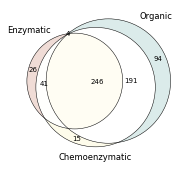

In [22]:
#https://www.python-graph-gallery.com/173-elaborated-venn-diagram
v = venn3(subsets = [bkms_found, reaxys_found, chemoenzymatic_found], set_labels = ('Enzymatic', 'Organic', 'Chemoenzymatic'), 
      alpha = 0.4, set_colors = ((219/255,169/255,154/255), (167/255,207/255,203/255), (254/255, 248/255, 206/255)))

c = venn3_circles(subsets = [bkms_found, reaxys_found, chemoenzymatic_found], 
                  linestyle='solid', lw = 0.5)

In [23]:
len(bkms_found)+ len(reaxys_found) + len(chemoenzymatic_found)

1345

In [24]:
len(chemoenzymatic_found & reaxys_found - bkms_found)

191

# Fraction of molecules that could benefit from chemoenzymatic synthesis

In [25]:
save_prefix = '/Users/Itai/Box Sync/Grad/Manuscripts/Chemonzymatic_planner/matplotlib_figures/3Aug2021'

shortest_paths_no_inf = shortest_paths.copy()
for smiles in shortest_bio_paths_from_enumeration:
    shortest_paths_no_inf.loc[smiles, 'bkms,reaxys'] = shortest_bio_paths_from_enumeration[smiles]
shortest_paths_no_inf[shortest_paths_no_inf==np.inf] = np.nan
shortest_paths_no_inf = shortest_paths_no_inf.dropna(subset=['reaxys', 'bkms,reaxys'])

shortest_paths_cascade_no_inf = shortest_paths_cascade.copy()
for smiles in shortest_bio_paths_cascade_from_enumeration:
    shortest_paths_cascade_no_inf.loc[smiles, 'bkms,reaxys'] = shortest_bio_paths_cascade_from_enumeration[smiles]
shortest_paths_cascade_no_inf[shortest_paths_cascade_no_inf==np.inf] = np.nan
shortest_paths_cascade_no_inf = shortest_paths_cascade_no_inf.dropna(subset=['reaxys', 'bkms,reaxys'])

['≥ 5 steps shorter', '4 steps shorter', '3 steps shorter', '2 steps shorter', '1 step shorter', 'Equivalent length', 'Only longer']
[4, 7, 7, 13, 42, 162, 196]
Total number of pathways compared: 431


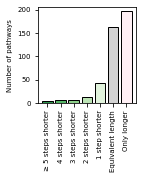

In [26]:
plot_distance_comparison_bars(shortest_paths_no_inf.loc[:, 'bkms,reaxys'].dropna(), 
                              shortest_paths_no_inf.loc[:, 'reaxys'].dropna(), 
                              None)

['≥ 5 steps shorter', '4 steps shorter', '3 steps shorter', '2 steps shorter', '1 step shorter', 'Equivalent length', 'Only longer']
[9, 10, 15, 20, 62, 150, 165]
Total number of pathways compared: 431


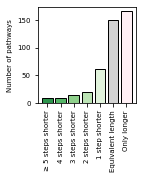

In [27]:
plot_distance_comparison_bars(shortest_paths_cascade_no_inf.loc[:, 'bkms,reaxys'].dropna(), 
                              shortest_paths_cascade_no_inf.loc[:, 'reaxys'].dropna(), 
                              None)

## Only display paths with 'rare' enzyme chemistry

In [28]:
only_chemenz = any_path_found.index[(any_path_found.loc[:, 'bkms,reaxys'] & ~any_path_found.loc[:, 'reaxys'])]

In [30]:
unique_enz_shortest_path_dict = {}
non_reaxys_enz_shortest_path_dict = {}
for smiles in only_chemenz:
    #first ablate the unique enz
    g = graph_dict[smiles]['bkms,reaxys']
    chem_nodes = [n for n in g.nodes if '>>' not in n]
    starting_nodes = [n for n in chem_nodes if g.nodes[n]['terminal']]
    
    ablated_g = g.copy()
    rxn_nodes = [n for n in g.nodes if '>' in n]
    for n in rxn_nodes:
         if len(set(g.nodes[n]['tforms']).intersection(unique_enzyme_templates)) > 0:
            ablated_g.remove_node(n)
    spg = metabolic_dijkstra(ablated_g, starting_nodes)
    unique_enz_shortest_path_dict[smiles] = spg.nodes[smiles]['path_length']
    
    rxn_nodes = [n for n in ablated_g.nodes if '>' in n]
    for n in rxn_nodes:
         if len(set(ablated_g.nodes[n]['tforms']).intersection(non_reaxys_enzyme_templates)) > 0:
            ablated_g.remove_node(n)
    spg = metabolic_dijkstra(ablated_g, starting_nodes)
    non_reaxys_enz_shortest_path_dict[smiles] = spg.nodes[smiles]['path_length']
    
    #then ablate the 

In [31]:
spg_dict['C=C(C)[C@@H]1CC=C(C)C[C@@H]1O']['bkms'].nodes['C=C(C)[C@@H]1CC=C(C)C[C@@H]1O']

{'type': 'chemical',
 'as_reactant': 0,
 'purchase_price': 0.0,
 'as_product': 0,
 'terminal': False,
 'path_length': 1,
 'visited': False,
 'shortest_pathway': ['C=C(C)[C@@H]1CC=C(C)CC1>>C=C(C)[C@@H]1CC=C(C)C[C@@H]1O']}

11 targets require uniquely enzymatic chemistry:


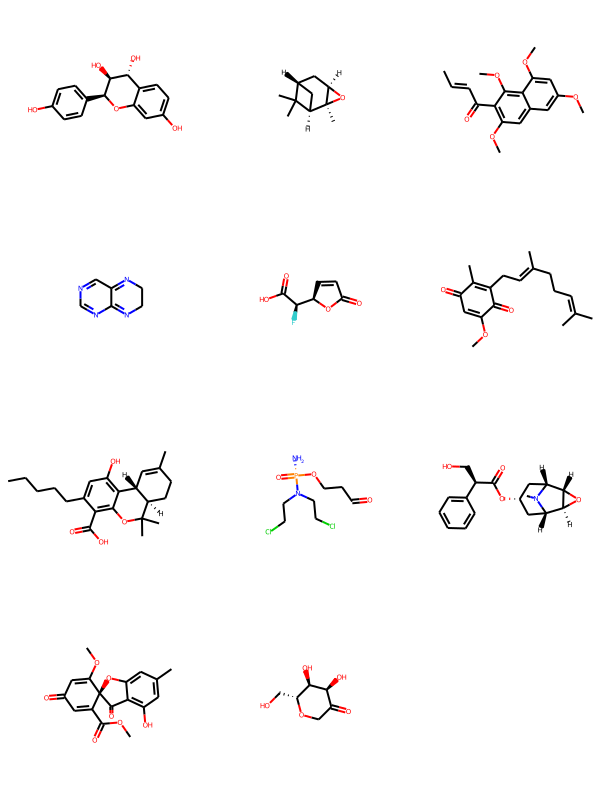

In [32]:
require_non_reaxys = [x for x in non_reaxys_enz_shortest_path_dict if non_reaxys_enz_shortest_path_dict[x]==np.inf]
print ('{} targets require uniquely enzymatic chemistry:'.format(len(require_non_reaxys)))
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in require_non_reaxys])



6 targets require uniquely enzymatic chemistry:


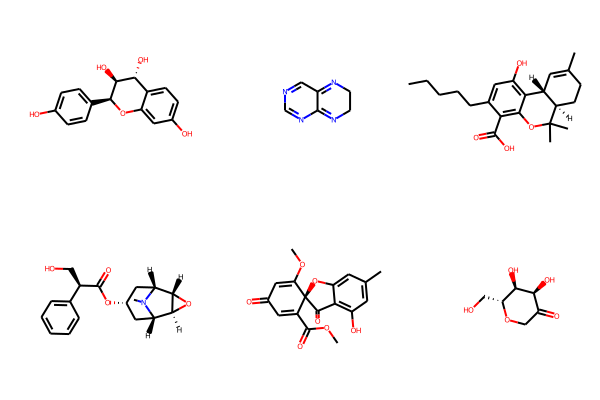

In [33]:
require_unique_enz  = [x for x in unique_enz_shortest_path_dict if unique_enz_shortest_path_dict[x]==np.inf]
print ('{} targets require uniquely enzymatic chemistry:'.format(len(require_unique_enz)))
Chem.Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in require_unique_enz])
